<a href="https://colab.research.google.com/github/moiroudelliott/hough/blob/main/Hough_polaire_trous.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


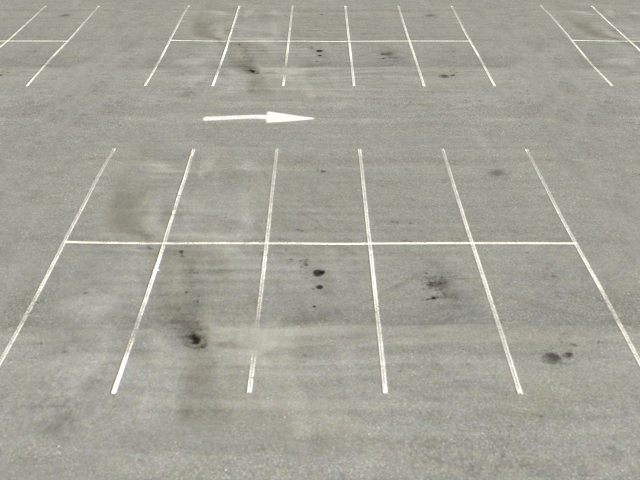

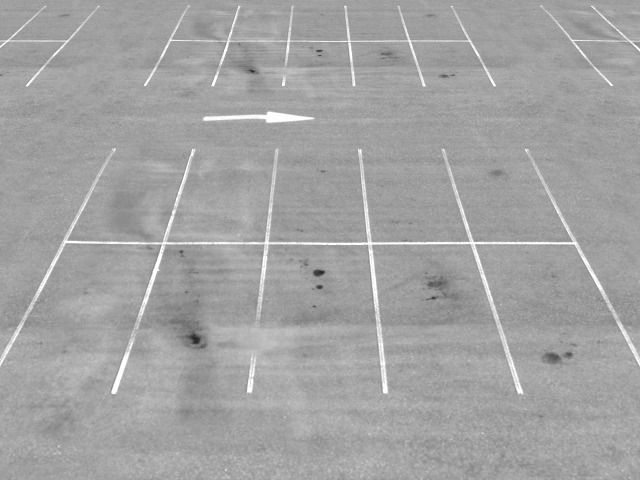

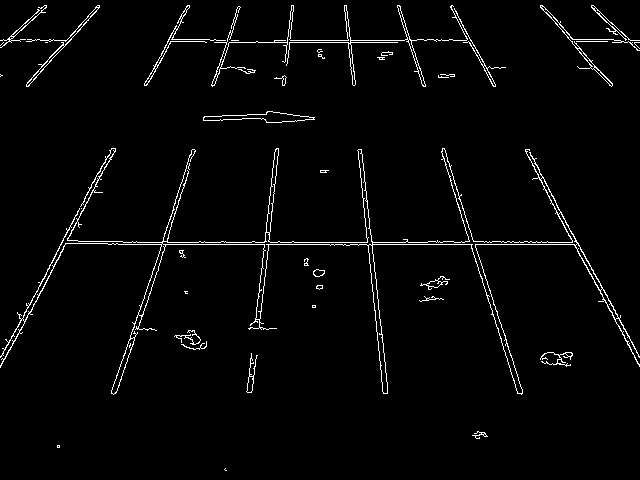

In [ ]:
# Les modules :

from google.colab import drive
import sys
import math
import cv2 as cv
import numpy as np
import math as m
from google.colab.patches import cv2_imshow

# Accès au fichiers du drives :

drive.mount('/content/drive')

# Importation de l'image :, 

path='/content/drive/My Drive/python/lines.png'
sudoku = cv.imread(path)
cv2_imshow(sudoku)
# Je commence par griser l'image :
gray=cv.cvtColor(sudoku, cv.COLOR_BGR2GRAY)

cv2_imshow(gray)
print("==============================================================")

# Puis j'effectue la détection de contour canny :
canny = cv.Canny(gray, 50, 200, None, 3)

cv2_imshow(canny)

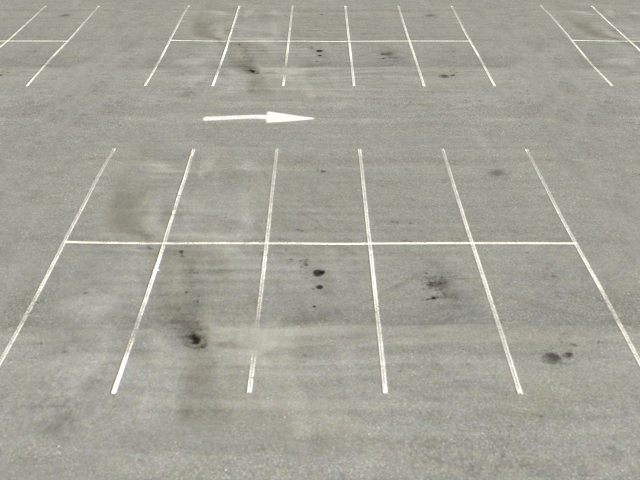

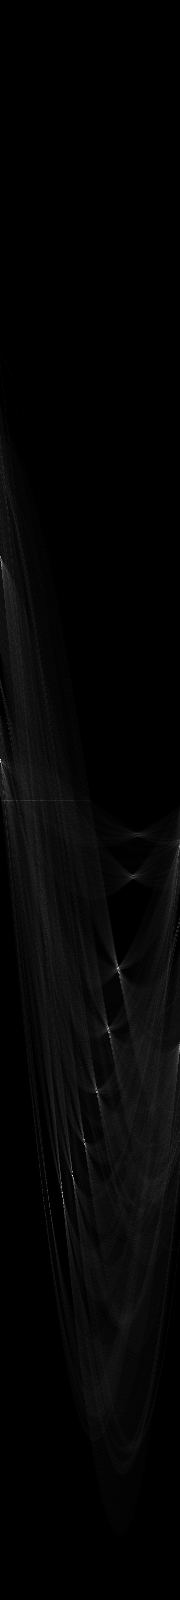

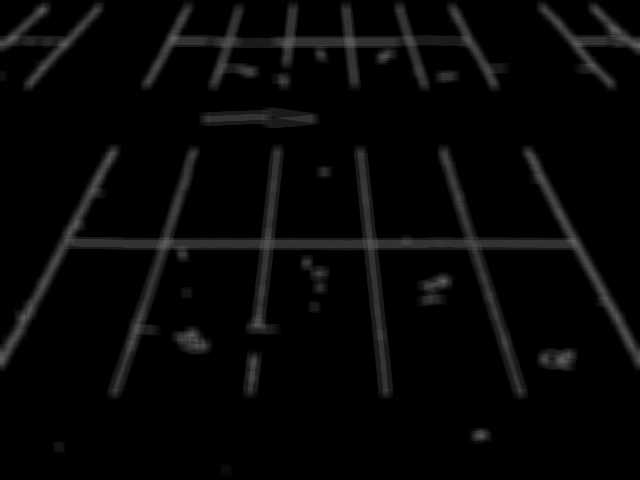

[[0, 247], [0, 247], [53, 246], [562, 237], [563, 237], [582, 237]]
[[640, -3273], [282, 91], [281, 108], [279, 128], [277, 144], [257, 335], [255, 349], [250, 398]]
[[0, 45], [77, 44], [160, 43], [477, 37], [558, 36], [634, 34]]
[[640, -1227], [239, 0], [239, 2], [209, 92], [203, 112], [198, 125], [192, 145], [109, 400]]
[[0, -1217], [424, 92], [440, 144], [523, 400]]
[[0, 39], [81, 39], [163, 39], [478, 39], [561, 39], [640, 39]]
[[0, -836], [443, 0], [446, 4], [492, 92], [521, 146], [640, 369]]
[[640, -884], [142, 91], [115, 144], [0, 369]]
[[0, 238], [0, 238], [57, 239], [589, 248]]
[[0, -3322], [355, 91], [360, 145], [387, 399]]


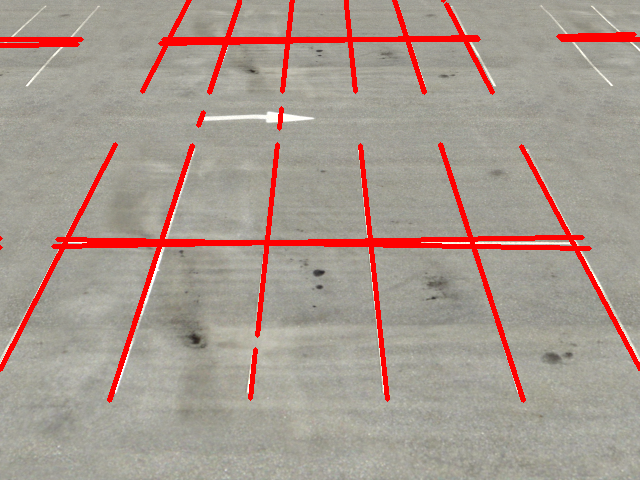

In [ ]:
def houghLine(image, incr):
  # On récupère la taille de l'image
  haut = len(image)
  larg = len(image[0])
  # On calcule la distance max en utilisant le théorème de pythagore
  dMax = int(m.sqrt(haut ** 2 + larg ** 2))
  # On fait un tableau de 180 radiant entre pi/2 et -pi/2
  thetas = np.deg2rad(np.arange(-90, 90))
  # On crée notre accumulateur qui fera 2 fois distance maximum x 180° (de -90 à 90)
  accumulator = np.zeros((dMax * 2, len(thetas)), dtype=np.uint8)

  # On boucle ensuite dans tous les pixels de l'image
  for y in range(haut):
      for x in range(larg):
        # Quand on trouve un pixel foncé on continue
        if image[y][x] == 255:
          # On boucle dans les x de l'accumulateur
          for o in range(len(thetas)):
            # On calcule le rayon r avec la formule r = x*cos(o)+y*sin(o)
            r = x * m.cos(thetas[o]) + y * m.sin(thetas[o])
            # Ensuite nous incrémentons l'accumulateur avec incr
            accumulator[int(r) + dMax, o] += incr
  return accumulator

def proche(co1, co2, acc):
  res = False
  haut = len(acc)
  distx = abs(co1[0]-co2[0])
  disty = abs(co1[1]-co2[1])
  if distx + disty < 12:
    res = True
  return res

def coordonneesMax(img, n):

  # On définis comme mémoire d'origine un tableau de n point (0, 0).
  res=[(0, 0)]*n
  min = 0
  # Puis nous allons boucler sur tous les pixels de l'image.
  for y in range(len(img)):
    for x in range(len(img[0])):
      # on définis le minimum à l'indice 0
      # On boucle sur la taille longueur du tableau -1
      # Si le point aux indices est plus clair que celui qu'on avais dans res à l'indice min, on le remplace.

      if img[y][x] > img[res[min][1]][res[min][0]]:
        val = True
        for i in range(len(res)):

          if proche(res[i], (x, y), img):
            val = False
            if img[res[i][1]][res[i][0]]<img[y][x]:
              res[i]=(x, y)

        if val:
          res[min] = (x, y)

        for i in range(len(res)):
          # On compare le point stocker dans res à l'indice minimum avec le point dans res à l'indice i + 1
          if img[res[min][1]][res[min][0]] > img[res[i][1]][res[i][0]]:
            # On met à jour l'indice min
            min = i


  return res

def co_segments(tabCo, img, canny, acc):
  # On récupère la taille de l'image
  haut = len(img)
  larg = len(img[1])

  cannyBlur = cv.blur(canny, [10, 10]) 
  cv2_imshow(cannyBlur)

  # On en sort les thetas en repassant les degrés en radiants et les rayons
  co_pol = []
  res = []
  for co in tabCo:
    theta = np.deg2rad(co[0] - 90)
    r = co[1] - int(m.sqrt(haut ** 2 + larg ** 2))
    co_pol.append((theta, r))
  for _ in range(len(co_pol)):
    res.append([])

  for co in range(len(co_pol)):
    y_min = int(co_pol[co][1] / (m.sin(co_pol[co][0])+0.001))
    y_max = int((( - m.cos(co_pol[co][0])) / (m.sin(co_pol[co][0]) + 0.001)) * larg + co_pol[co][1] / (m.sin(co_pol[co][0])+0.001))
    coeff = (y_min - y_max)/(0-larg)

    coul = True

    if coeff > 1 or coeff < -1:
      if coeff >= 0:
        res[co].append([0, y_min])
      else :
        res[co].append([larg, y_max])

      for y in range(0, haut, 1):

        x = int((y - (co_pol[co][1] / (m.sin(co_pol[co][0])+0.001)))/(( - m.cos(co_pol[co][0])) / (m.sin(co_pol[co][0])+0.001)))
        if x < larg and x > 0:
          coul2 = cannyBlur[y][x] > 0
          if coul != coul2:
            coul = coul2
            res[co].append([int((y - (co_pol[co][1] / (m.sin(co_pol[co][0])+0.001)))/(( - m.cos(co_pol[co][0])) / (m.sin(co_pol[co][0])+0.001))), y])

      if len(res[co])%2==1:
        if coeff >= 0:
          res[co].append([larg, y_max])
        else :
          res[co].append([0, y_min])    
    else:
      res[co].append([0, y_min])
      for x in range(0, larg, 1):
        y = int((( - m.cos(co_pol[co][0])) / (m.sin(co_pol[co][0])+0.001)) * x + co_pol[co][1] / (m.sin(co_pol[co][0])+0.001))
        if y < haut and y > 0:
          coul2 = cannyBlur[y][x] > 0
          if coul != coul2:
            coul = coul2
            res[co].append([x, int((( - m.cos(co_pol[co][0])) / (m.sin(co_pol[co][0])+0.001)) * (x) + co_pol[co][1] / (m.sin(co_pol[co][0])+0.001))])
      if len(res[co])%2 == 1:
          res[co].append([larg, y_max])
    print(res[co])
  return res


cv2_imshow(sudoku)

acc = houghLine(canny, 1)
cv2_imshow(acc)

# On récupère les coordonnées des pixels les plus clair de l'accumulateur
c_max = coordonneesMax(acc, 10)

# On trace des lignes sur les coordonnées trouvées

tab_y = co_segments(c_max, sudoku, canny, acc)

img = np.copy(sudoku)

for droite in tab_y:
  for seg in range(0, len(droite), 2):
    cv.line(img, droite[seg], droite[seg+1], (0, 0, 255), 3)

cv2_imshow(img)